In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,TensorDataset
from tqdm import tqdm

from sklearn.metrics import accuracy_score, f1_score, classification_report,top_k_accuracy_score,roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn import datasets
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,VotingClassifier,GradientBoostingClassifier,HistGradientBoostingClassifier,AdaBoostClassifier

def seedEverything(seed=0):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
    torch.backends.cudnn.enabled = False 
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
seed=42
seedEverything(seed)

fontSizeSetLarge=18
fontSizeSetMedium=14
signalLims=[(0,65000),(0,6000), (0,4000), (0,4000)]
pceLims=(5,17.5)
vocLims=(0.9,1.15)
jscLims=(16,22)
ffLims=(40,75)  

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
filename='data/data.h5'

## read in and preprocess data

In [3]:
# Read the HDF5 file into a DataFrame
readDF=pd.read_hdf(filename, 'df') 

# Mapping from molarity values to discrete class labels
class_mapping = {
    0.56: 0,
    0.61: 1,
    0.67: 2,
    0.75: 3,
    0.84: 4,
}
# Apply the class mapping to create a 'class' column in the DataFrame
readDF['class'] = readDF['molarity'].replace(class_mapping)

# Define samples that will be used as test data     
test_sub_list=[ 'DFN', 'DGO', 'DHT','DIA', 'DIB', 'DIC','DID', 'DIE', 
               'DIF','DIG', 'DIH', 'DII','DIJ', 'DIK', 'DIL']

# Define sub-lists for different training folds during 5-fold cross-validation
train_fold0_sub_list=['DDM', 'DFA', 'DFB', 'DFD', 'DFE','DFG', 'DFH', 'DFJ', 'DFK']
train_fold1_sub_list=['DEM', 'DEN','DFC',  'DFF', 'DGD', 'DFI', 'DGG', 'DFL', 'DGJ']
train_fold2_sub_list=['DEO', 'DEP','DGB', 'DGC', 'DGE','DGH', 'DGI','DGK', 'DGL']
train_fold3_sub_list=['DEQ', 'DER','DHA', 'DHB','DHD', 'DHE','DHG', 'DHH', 'DHJ']
train_fold4_sub_list=['DDN','DGA','DFM', 'DHC', 'DHF', 'DHI', 'DHL', 'DGF','DHK']

# Drop samples not in any fold from the training DataFrame and reset its index
indexDropTrain = readDF[ ~readDF['expID'].isin(train_fold0_sub_list+train_fold1_sub_list+train_fold2_sub_list+train_fold3_sub_list+train_fold4_sub_list ) ].index
trainDF=readDF.drop(indexDropTrain)
trainDF=trainDF.reset_index(drop=True)

# Assigning fold numbers to each sample in trainDF
for element in trainDF[trainDF['expID'].isin(train_fold0_sub_list)].index.tolist():
    trainDF.loc[element,"fold"]=0
for element in trainDF[trainDF['expID'].isin(train_fold1_sub_list)].index.tolist():
    trainDF.loc[element,"fold"]=1
for element in trainDF[trainDF['expID'].isin(train_fold2_sub_list)].index.tolist():
    trainDF.loc[element,"fold"]=2
for element in trainDF[trainDF['expID'].isin(train_fold3_sub_list)].index.tolist():
    trainDF.loc[element,"fold"]=3
for element in trainDF[trainDF['expID'].isin(train_fold4_sub_list)].index.tolist():
    trainDF.loc[element,"fold"]=4
    
# Drop samples which are not in the test list from the DataFrame to create a test set and reset its index
indexDropTest = readDF[ ~readDF['expID'].isin(test_sub_list) ].index
testDF=readDF.drop(indexDropTest)
testDF=testDF.reset_index(drop=True)

# Construct feature matrices for training and testing by horizontally stacking the specified signal columns
X_train = pd.DataFrame(data = np.hstack((np.vstack(trainDF["ND"].to_numpy()),np.vstack(trainDF["LP725"].to_numpy()),
            np.vstack(trainDF["LP780"].to_numpy()),np.vstack(trainDF["SP775"].to_numpy()))))
X_test = pd.DataFrame(data = np.hstack((np.vstack(testDF["ND"].to_numpy()),np.vstack(testDF["LP725"].to_numpy()),
            np.vstack(testDF["LP780"].to_numpy()),np.vstack(testDF["SP775"].to_numpy()))))

# Create target arrays for training and testing datasets
y_train = np.array(trainDF['class'])
y_test = np.array(testDF['class'])

## Plotting training data for different molarities

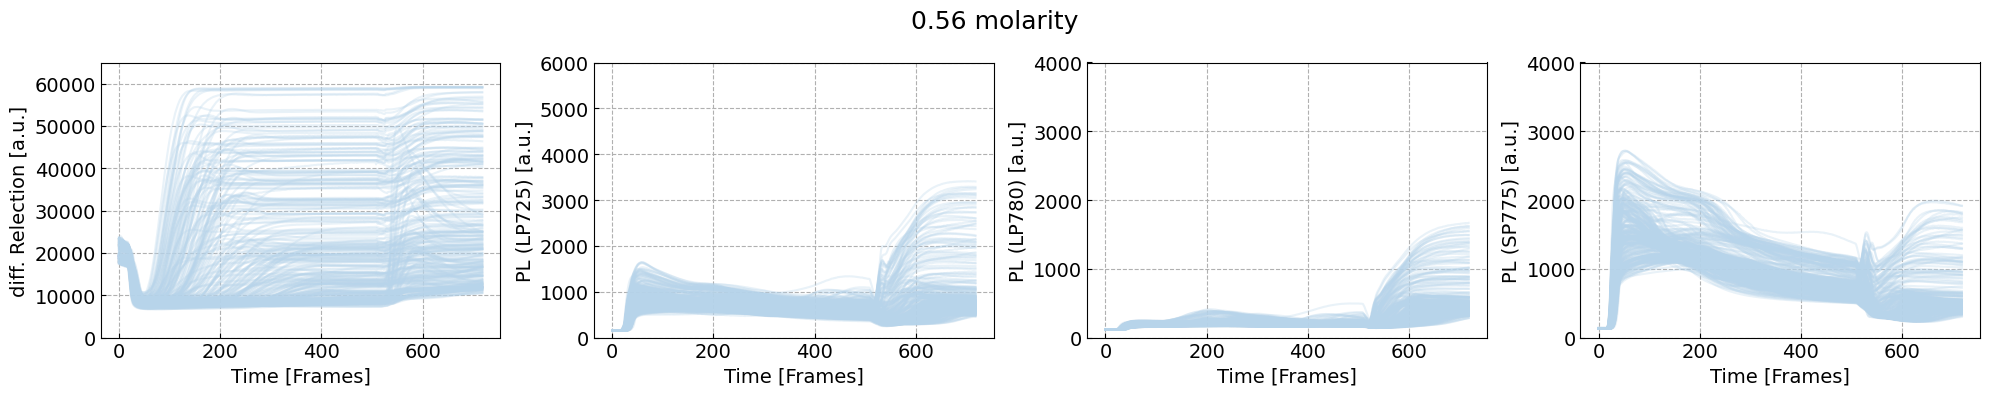

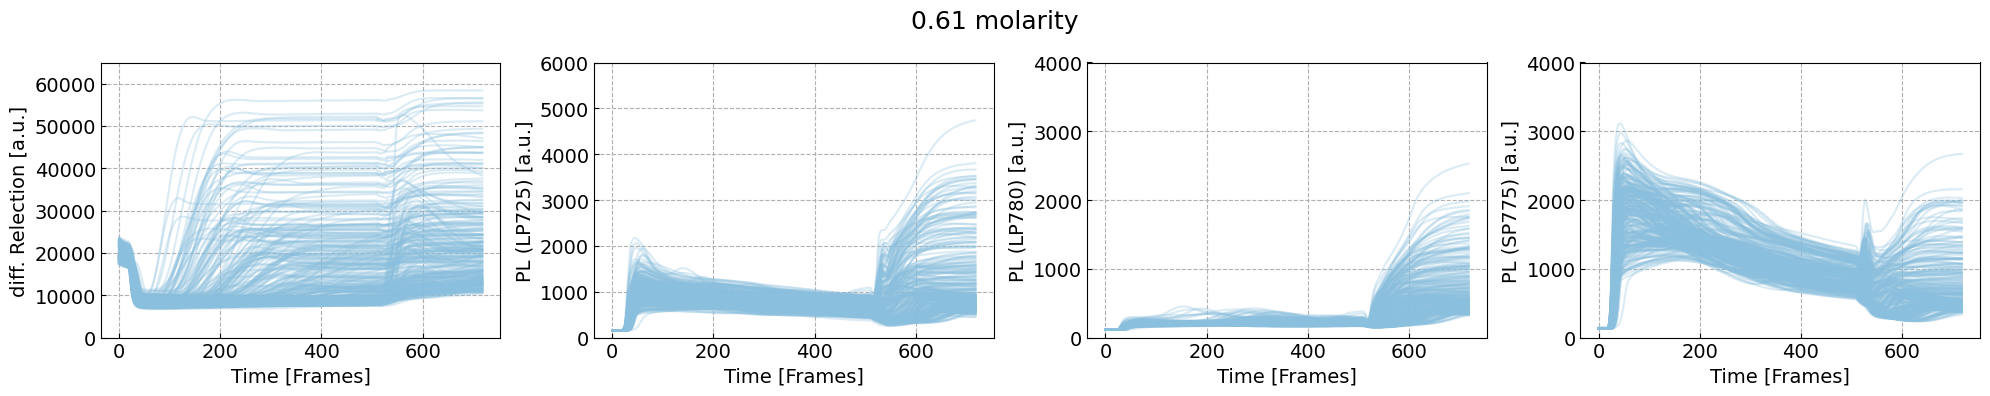

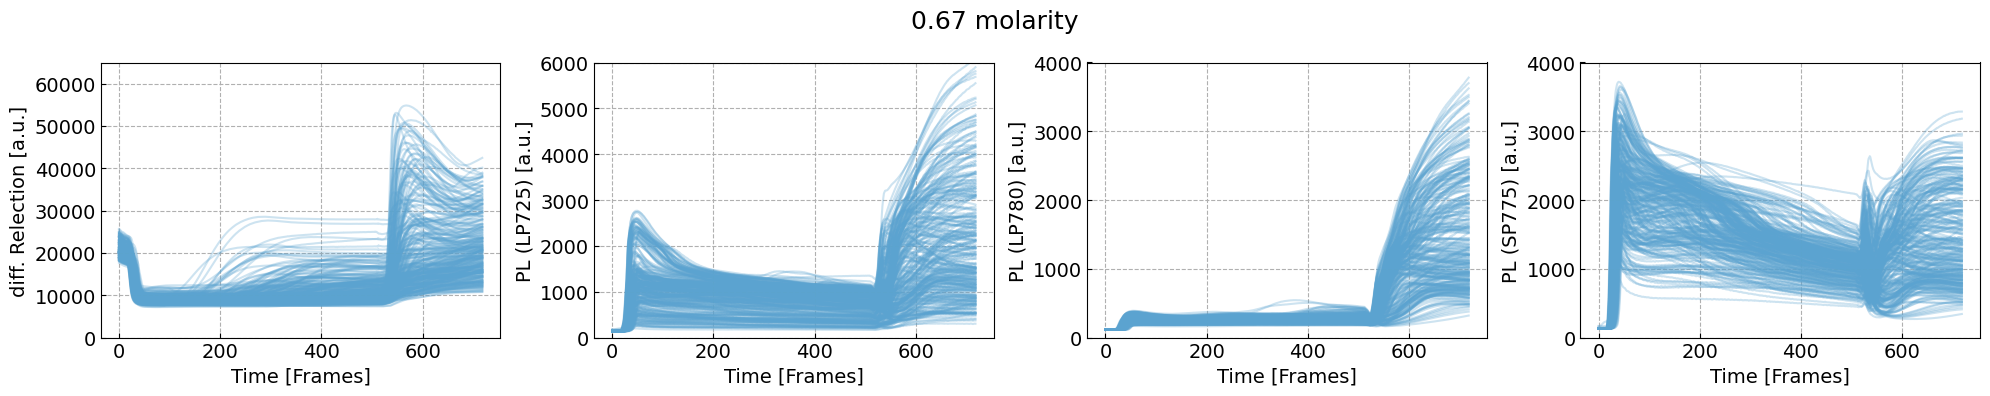

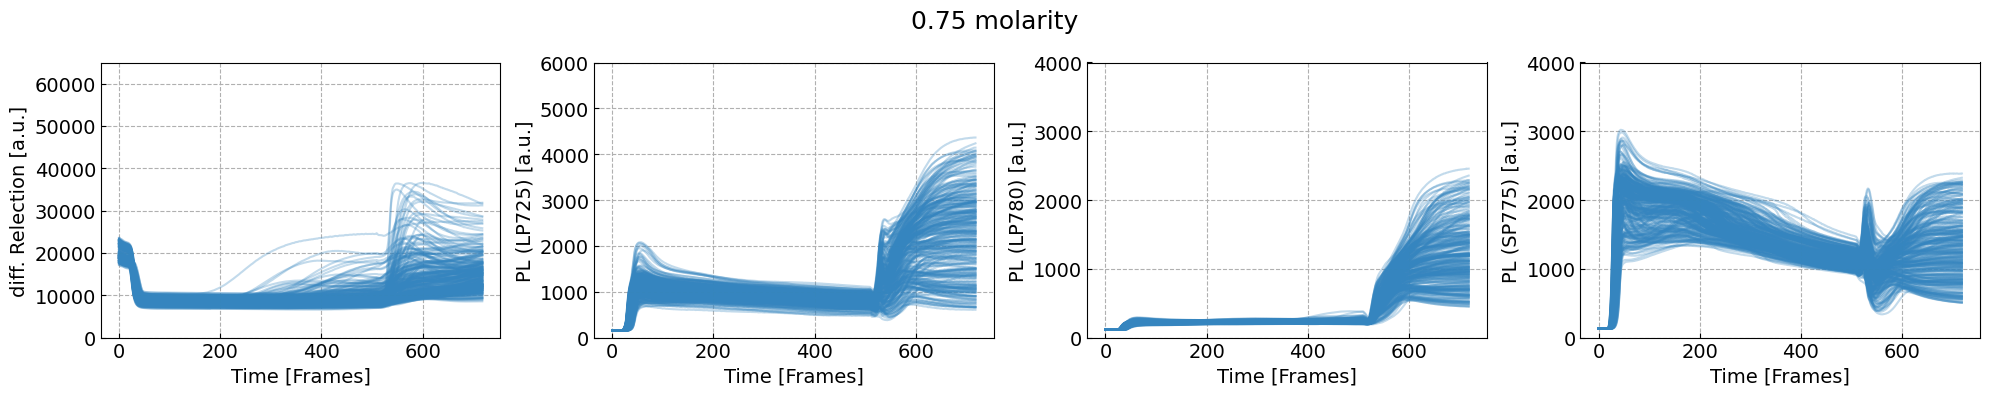

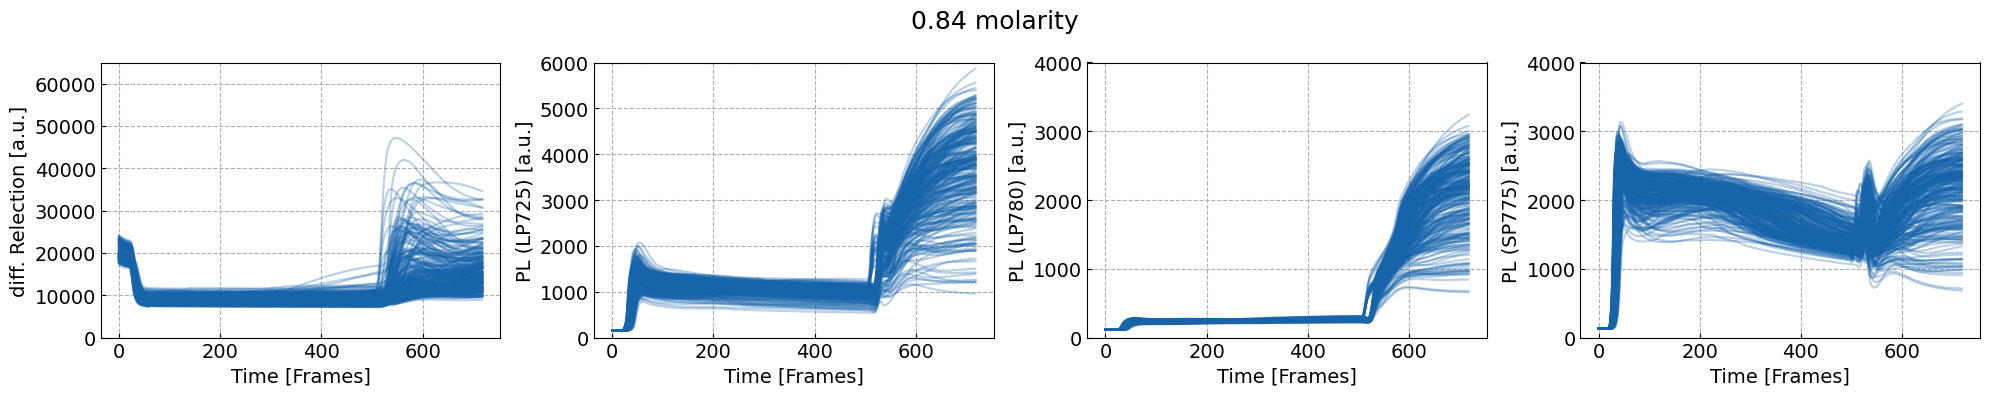

In [4]:
# Labels for molarities to be used in plot titles
labels=["0.56", "0.61", "0.67", "0.75", "0.84" ]
# List of signals to be plotted
signals=["ND","LP725","LP780","SP775"]

# Generate color maps for plotting
ks = np.linspace(0.2,0.99,7)
ks2 = np.linspace(0.3,0.8,5)
color_list_fig = []
color_list_fig_2 = []
cmap = plt.get_cmap('Reds')
cmap2 = plt.get_cmap('Blues')
for zz in range(len(ks)):
    color_list_fig.append(cmap(ks[zz]))
for zz in range(len(ks2)):
    color_list_fig_2.append(cmap2(ks2[zz]))

# Iterate through sorted unique molarity values present in the training DataFrame
for inn,molarity in enumerate(sorted(trainDF["molarity"].unique())):
     # Filter the DataFrame for the current molarity
    temp= trainDF[trainDF["molarity"]==molarity]  

    # Create subplots for the signals for the current molarity
    fig,ax =plt.subplots(1,4, figsize=(20,4))
    for iy, signal in enumerate(signals):
        # Plot each sample's signal for the current molarity
        for i in range(len(temp)):
            ax[iy].plot(temp.loc[temp.index[i],signal], color=color_list_fig_2[inn],alpha=0.3)
        ax[iy].set_xlabel("Time [Frames]", fontsize=14)
        ax[iy].set_ylim(signalLims[iy])
        ax[iy].grid(which="both", linestyle='--')
        ax[iy].tick_params(axis='both', which='major',direction="in", labelsize=14)
        
    fig.suptitle(labels[inn] +" molarity", fontsize=18)                             
    ax[0].set_ylabel("diff. Relection [a.u.]", fontsize=14)
    ax[1].set_ylabel("PL (LP725) [a.u.]", fontsize=14)
    ax[2].set_ylabel("PL (LP780) [a.u.]", fontsize=14)
    ax[3].set_ylabel("PL (SP775) [a.u.]", fontsize=14)
    plt.tight_layout()
    plt.show()



## Comparing classification results of neural network with classical machine learning methods

0 Dummy Classifier
Accuracy: 0.210
1 Logistic Regression
Accuracy: 0.796
2 Random Forest
Accuracy: 0.838
3 Naive Bayes
Accuracy: 0.662
4 K-Nearest Neighbors
Accuracy: 0.525
5 Support Vector Machine
Accuracy: 0.435
6 Decision Tree
Accuracy: 0.738
7 Gradient Boosting
Accuracy: 0.802
8 HistGradientBoosting
Accuracy: 0.863
9 AdaBoost
Accuracy: 0.650
10 Ensemble
Accuracy: 0.858


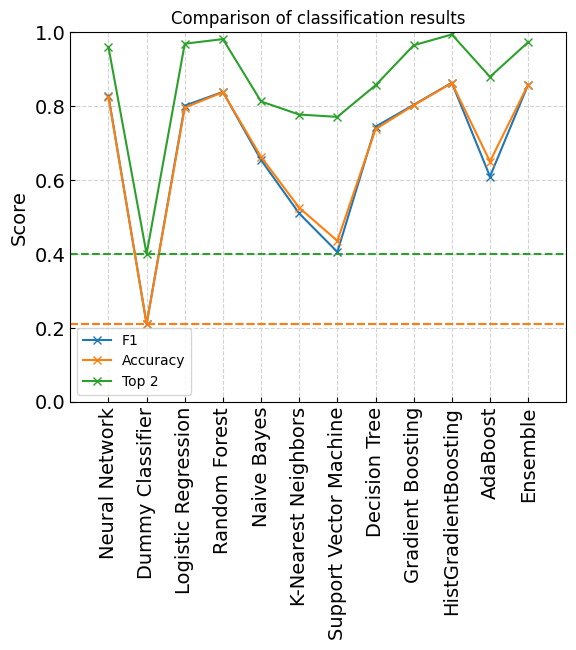

In [5]:
# Initialize the random state for reproducibility
rand,seedsRandom=np.random.seed(0),np.random.rand(1)*1000
randState= int(seedsRandom[0])

# Initialize lists to hold F1 scores, top-2 accuracy scores, and accuracy scores for up to 20 models
ls_f1=[] 
ls_top2=[] 
ls_accuracy=[] 

# Determined performance metrics of the neural network for comparison (see below in the notebook)
ls_f1.append(0.828)
ls_top2.append(0.960)
ls_accuracy.append(0.825)


# Initialize various classifiers with the current seed for reproducible results
dummy=DummyClassifier(strategy='uniform',random_state=randState)   
classifier1 = LogisticRegression(random_state=randState, solver= "liblinear",max_iter=1000)
classifier2 = RandomForestClassifier(n_estimators=100, random_state=randState)
classifier3 = GaussianNB()
classifier4 = KNeighborsClassifier(n_neighbors=10)
classifier5 = SVC(kernel='rbf', probability=True, random_state=randState)
classifier6 = DecisionTreeClassifier(max_depth=4, random_state=randState)
classifier7 = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=randState)
classifier8 = HistGradientBoostingClassifier(max_iter=100, random_state=randState)
classifier9 = AdaBoostClassifier(n_estimators=100, random_state=randState)

# Combine individual classifiers into an ensemble classifier using soft voting
ensamble_classifier = VotingClassifier( estimators=[('lr', classifier1), ('rf', classifier2), ('gnb', classifier3),
                                                    ('knn', classifier4), ('svc', classifier5), ('dt', classifier6), 
                                                    ('gb', classifier7), ('hgb', classifier8) , ('ab', classifier9)]
                                       , voting='soft')

# List of all models for iteration
models = [dummy, classifier1, classifier2, classifier3,classifier4,classifier5,classifier6, 
          classifier7, classifier8,classifier9, ensamble_classifier]
# Labels for each model to be used in plots and prints
ticks = ['Neural Network', 'Dummy Classifier','Logistic Regression', 'Random Forest', 'Naive Bayes',
         'K-Nearest Neighbors', 'Support Vector Machine', 'Decision Tree', 'Gradient Boosting',
         'HistGradientBoosting','AdaBoost','Ensemble']
# Pair each model with its label for processing
zipper=zip(models, ticks)

# Train each model on training set, predict on the test set, and calculate performance metrics
for iyy,(classifier, label) in enumerate(zipper):
    print(iyy, ticks[iyy+1])
    
    # Train the model                                                
    classifier.fit(X_train, y_train)
    # Predict on the test set
    y_pred = classifier.predict(X_test.values)
    
    # Calculate and print the model's performance metrics
    f1_score_macro = f1_score(y_test, y_pred, average="macro")
    top2_score=top_k_accuracy_score(y_test, classifier.predict_proba(X_test.values), k=2)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy: %0.3f" % (accuracy))
    # Append the performance metrics to their respective lists.
    ls_f1.append(f1_score_macro)
    ls_top2.append(top2_score)
    ls_accuracy.append(accuracy)

# Plot the mean F1 score, accuracy, and top-2 accuracy for each model
plt.plot(np.arange(1,len(ls_f1)+1),ls_f1,"x-",label="F1", color="tab:blue")
plt.plot(np.arange(1,len(ls_accuracy)+1),ls_accuracy,"x-",label="Accuracy", color="tab:orange")
plt.plot(np.arange(1,len(ls_top2)+1),ls_top2,"x-",label="Top 2", color="tab:green")

plt.ylabel("Score", fontsize=14)
plt.xticks(range(1,1+len(ticks)),ticks, rotation = 90)
plt.xlim(0,len(ticks)+1)
plt.axhline(y=ls_f1[1], linestyle="--", color="tab:blue")
plt.axhline(y=ls_accuracy[1], linestyle="--", color="tab:orange")
plt.axhline(y=ls_top2[1], linestyle="--", color="tab:green")
plt.ylim(0,1)
plt.title("Comparison of classification results")
plt.grid(which="both", linestyle='--', color="lightgrey")
plt.tick_params(axis='both', which='major',direction="in", labelsize=14) 
plt.legend()
plt.show()

## Training a neural network for molarity classification

In [6]:
# Definition of a neural network model
class NN_Model(nn.Module):
    def __init__(self, input_size, output_size):
        super(NN_Model, self).__init__()
        
        self.fc1 = nn.Linear(input_size, 200)
        self.fc2 = nn.Linear(200, 500)
        self.fc3 = nn.Linear(500, 1000)
        self.fc4 = nn.Linear(1000, 500)
        self.fc5 = nn.Linear(500, 200)
        self.fc6 = nn.Linear(200, 5)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        x = self.relu(x)
        x = self.fc5(x)
        x = self.relu(x)
        x = self.fc6(x)

        return x

****************************************************************************************************
*                                                                                                  *
*                      training on training set using 5-fold cross-validation                      *
*                                                                                                  *
****************************************************************************************************
fold 0  (train_size: 1152 , valid_size: 288 )


100%|██████████| 1000/1000 [00:26<00:00, 37.78it/s]


validation result for fold 0 :   acc:  0.71 , top2-score:  0.91
****************************************************************************************************
fold 1  (train_size: 1152 , valid_size: 288 )


100%|██████████| 1000/1000 [00:24<00:00, 40.50it/s]


validation result for fold 1 :   acc:  0.8 , top2-score:  0.96
****************************************************************************************************
fold 2  (train_size: 1152 , valid_size: 288 )


100%|██████████| 1000/1000 [00:24<00:00, 40.46it/s]


validation result for fold 2 :   acc:  0.78 , top2-score:  0.99
****************************************************************************************************
fold 3  (train_size: 1152 , valid_size: 288 )


100%|██████████| 1000/1000 [00:24<00:00, 41.02it/s]


validation result for fold 3 :   acc:  0.87 , top2-score:  0.97
****************************************************************************************************
fold 4  (train_size: 1152 , valid_size: 288 )


100%|██████████| 1000/1000 [00:24<00:00, 40.88it/s]


validation result for fold 4 :   acc:  0.82 , top2-score:  0.97
****************************************************************************************************


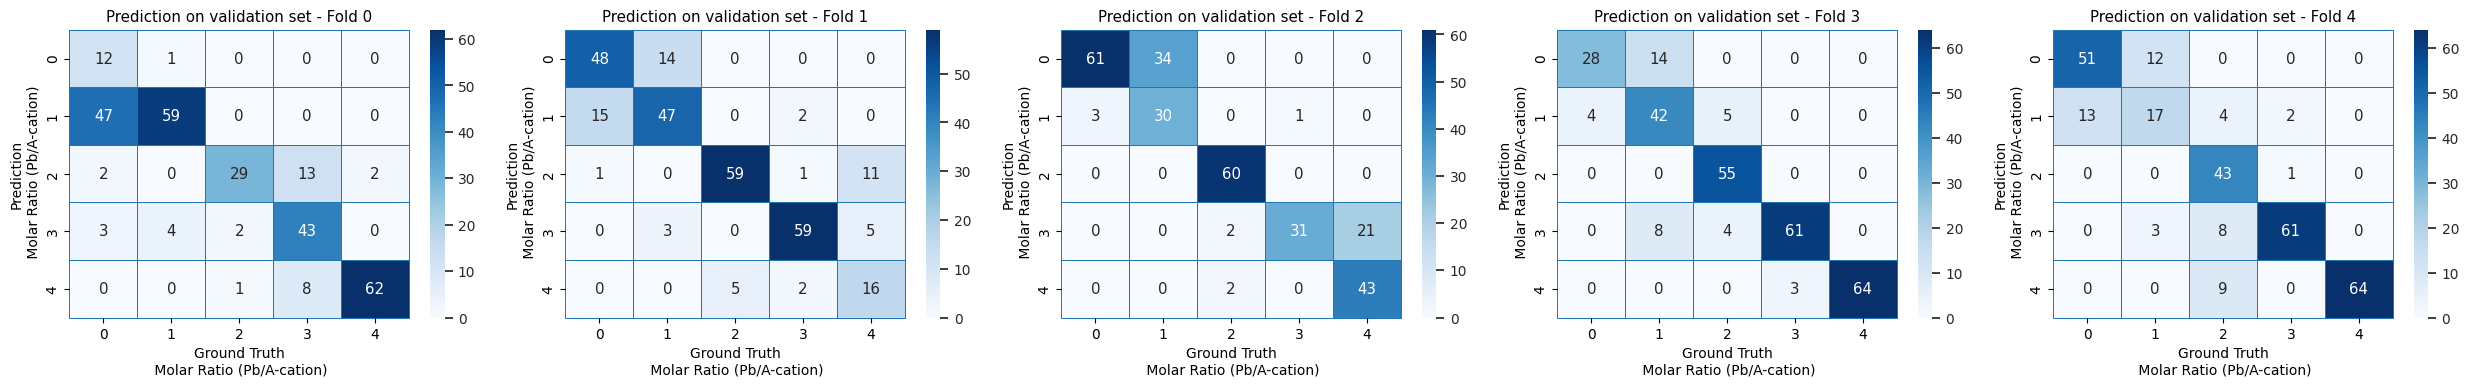

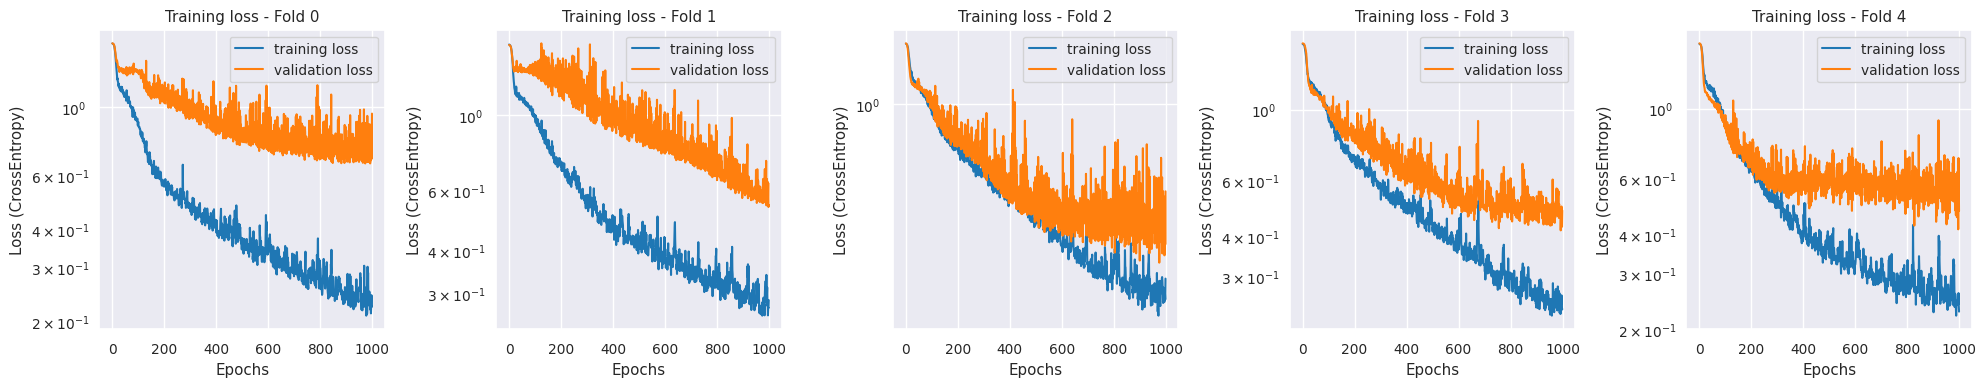

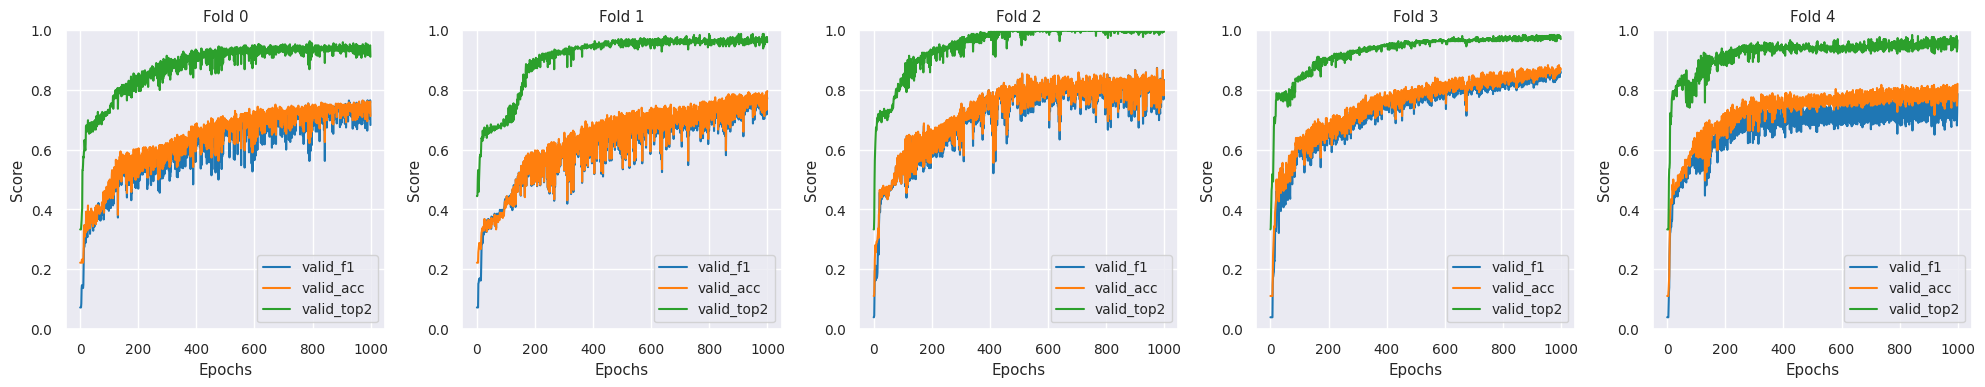

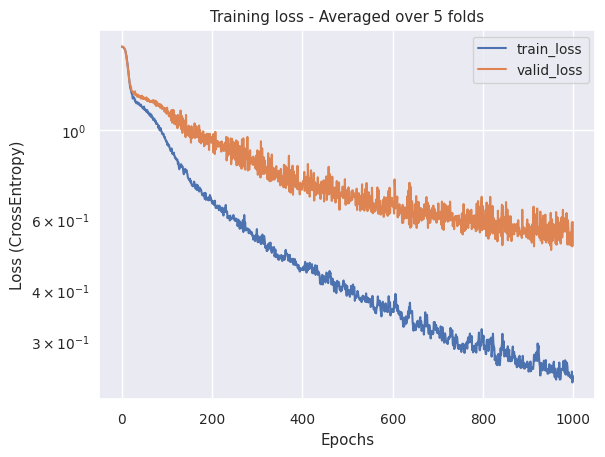

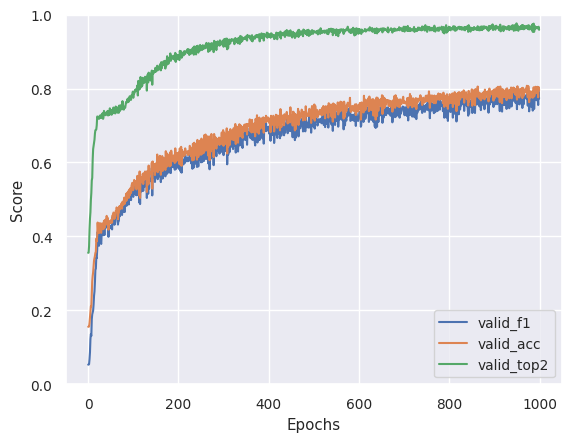

last loss 0.59 , best loss: 0.51  for 951 epochs
****************************************************************************************************
*                                                                                                  *
*                          training on entire train set (for  952  epochs)                         *
*                                                                                                  *
****************************************************************************************************


100%|██████████| 951/951 [00:20<00:00, 45.58it/s]


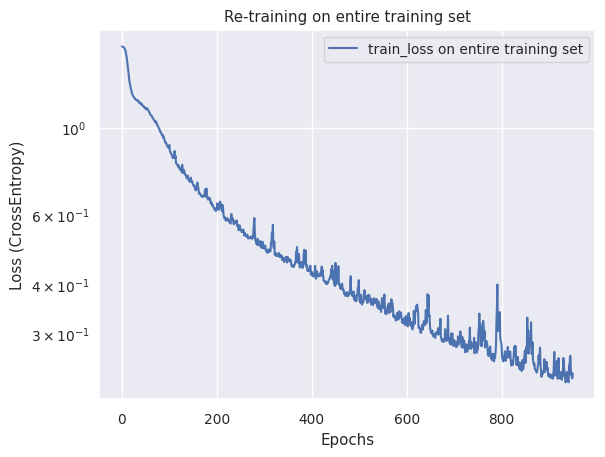

****************************************************************************************************
*                                                                                                  *
*                                    testing on held-out testset                                   *
*                                                                                                  *
****************************************************************************************************


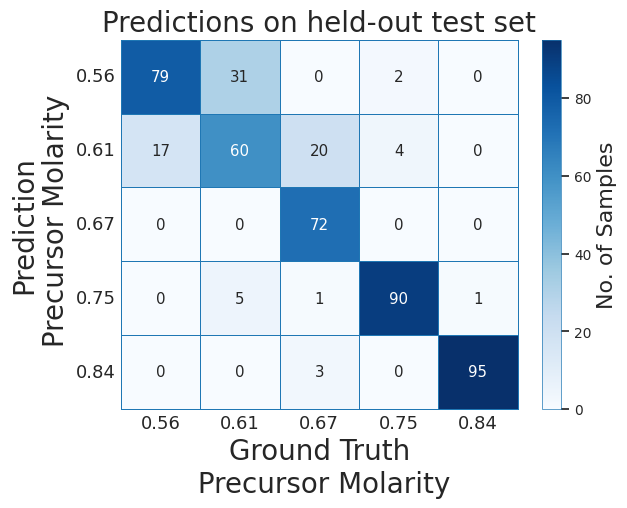

testing result on held-out test set:  acc:  0.825 , top2-score:  0.96


In [7]:
seedEverything(seed)
# Scaler value for normalizing data
scaler=2**16

# Training parameters
learning_rate = 0.0001
batch_size = 512
shuffle = True # Shuffle data in the DataLoader
num_epochs=1000 # Number of training epochs
criterion = nn.CrossEntropyLoss() # Loss function for classification
optimize=optim.Adam # Optimization algorithm
weight_decay=0.0001 # Weight decay for regularization
model_to_use=NN_Model

print("*"*100)
print("*", " "*96,"*")
print("*"," "*20, "training on training set using 5-fold cross-validation"," "*20,"*")
print("*", " "*96,"*")
print("*"*100)

# Lists for storing fold-wise losses and performance metrics
valid_fold_losses=[]
train_fold_losses=[]
f1_fold_list=[]
acc_fold_list=[]
top2_fold_list=[]

fig,ax=plt.subplots(1,5,figsize=(25,4))
last_loss=[]

# 5-fold cross-validation
for fold in range(5):
    
    # Splitting the training dataset into training and validation sets based on fold    
    temp_train=trainDF[trainDF["fold"]!=fold].copy()
    temp_valid=trainDF[trainDF["fold"]==fold].copy()
    
    # Data preprocessing: feature extraction, normalization, and conversion to tensors
    X_train = pd.DataFrame(data = np.hstack((np.vstack(temp_train["ND"].to_numpy()),np.vstack(temp_train["LP725"].to_numpy()),
                np.vstack(temp_train["LP780"].to_numpy()),np.vstack(temp_train["SP775"].to_numpy()))))/scaler
    X_valid = pd.DataFrame(data = np.hstack((np.vstack(temp_valid["ND"].to_numpy()),np.vstack(temp_valid["LP725"].to_numpy()),
                np.vstack(temp_valid["LP780"].to_numpy()),np.vstack(temp_valid["SP775"].to_numpy()))))/scaler
    
    y_train=pd.DataFrame(data=np.vstack(temp_train["class"].to_numpy()))
    y_valid=pd.DataFrame(data=np.vstack(temp_valid["class"].to_numpy()))
    
    X_train_tensor = torch.tensor(X_train.values.astype(np.float32))
    y_train_tensor = torch.tensor(y_train.values.astype(np.float32)) 
    X_valid_tensor = torch.tensor(X_valid.values.astype(np.float32))
    y_valid_tensor = torch.tensor(y_valid.values.astype(np.float32)) 

    # DataLoader setup for both training and validation sets
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)

    valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)
    valid_loader = DataLoader(valid_dataset, batch_size=len(valid_dataset), shuffle=shuffle)

    print("fold", fold, " (train_size:" , len(train_dataset),", valid_size:" , len(valid_dataset), ")")
    
    # Model initialization and optimizer setup
    input_size =  X_train.shape[1]  
    output_size = y_train.shape[1]  
    model = model_to_use(input_size, output_size).to(device)
    optimizer = optimize(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Lists for storing epoch-wise losses and performance metrics for the current fold
    valid_fold_losses.append([])
    train_fold_losses.append([])
    f1_fold_list.append([])
    acc_fold_list.append([])
    top2_fold_list.append([])

    # Training and validation loop
    for epoch in tqdm(range(num_epochs)):
        epoch_train_loss=[]
        epoch_valid_loss=[]

        # Training the model on 4 train splits
        for inputs, targets in train_loader:
            model.train()
            optimizer.zero_grad()
            outputs = model(inputs.to(device))
            loss = criterion(outputs, torch.max(targets, 1)[0].type(torch.LongTensor).to(device) )
            loss.backward()
            optimizer.step()
            epoch_train_loss.append(loss.cpu().detach().numpy())
        
        # Validating the model on 1 validation split
        for inputs_valid, targets_valid in valid_loader:
            model.eval()
            outputs_valid = model(inputs_valid.to(device))
            loss_valid = criterion(outputs_valid, torch.max(targets_valid, 1)[0].type(torch.LongTensor).to(device) )
            epoch_valid_loss.append(loss_valid.cpu().detach().numpy())

        # Update epoch-wise losses and metrics for the current fold
        train_fold_losses[fold].append(np.mean(epoch_train_loss))
        valid_fold_losses[fold].append(np.mean(epoch_valid_loss))
        f1_fold_list[fold].append( f1_score(targets_valid.to(device).cpu().detach().numpy()  , np.argmax(outputs_valid.to(device).cpu().detach().numpy(),axis=1), average="macro"))
        acc_fold_list[fold].append(accuracy_score(targets_valid.to(device).cpu().detach().numpy()  , np.argmax(outputs_valid.to(device).cpu().detach().numpy(),axis=1)))
        top2_fold_list[fold].append(top_k_accuracy_score(targets_valid.to(device).cpu().detach().numpy()  , outputs_valid.to(device).cpu().detach().numpy(), k=2,labels=np.unique(y_train)))
        


    loss_output = criterion(outputs_valid, torch.max(targets_valid, 1)[0].type(torch.LongTensor).to(device) ).cpu().detach().numpy()
    last_loss.append(loss_output)
    f1_fold=np.round(f1_score(targets_valid.to(device).cpu().detach().numpy()  , np.argmax(outputs_valid.to(device).cpu().detach().numpy(),axis=1), average="macro"), 2)
    acc_fold=np.round(accuracy_score(targets_valid.to(device).cpu().detach().numpy()  , np.argmax(outputs_valid.to(device).cpu().detach().numpy(),axis=1)),2)
    top2_fold=np.round(top_k_accuracy_score(targets_valid.to(device).cpu().detach().numpy()  , outputs_valid.to(device).cpu().detach().numpy(), k=2,labels=np.unique(y_train)),2)
    print("validation result for fold", fold, ":   acc: ", acc_fold, ", top2-score: ", top2_fold)
    print("*"*100)

    # Plotting confusion matrix for the validation set of the current fold
    cm = confusion_matrix(targets_valid.to(device).cpu().detach().numpy()  , np.argmax(outputs_valid.to(device).cpu().detach().numpy(),axis=1))
    sns.set(font_scale=0.9) 
    sns.heatmap(cm.transpose(), annot=True, ax=ax[fold], cmap="Blues", fmt="g", linewidths=0.5, linecolor='tab:blue', clip_on=False)  
    ax[fold].set_ylabel('Prediction\n Molar Ratio (Pb/A-cation)', fontsize=10)
    ax[fold].set_xlabel('Ground Truth\n Molar Ratio (Pb/A-cation)', fontsize=10)
    ax[fold].set_title("Prediction on validation set - Fold " + str(fold))
    
fig.tight_layout()
plt.show()

# Plot training and validation loss curves for each fold
fig,ax=plt.subplots(1,fold+1,figsize=(20,4))
for fold in range(len(train_fold_losses)):
    ax[fold].plot(train_fold_losses[fold], "tab:blue")
    ax[fold].plot([],[], "tab:blue", label="training loss")
    ax[fold].plot(valid_fold_losses[fold], "tab:orange")
    ax[fold].plot([],[], "tab:orange", label="validation loss")    
    ax[fold].legend()
    ax[fold].set_title("Training loss - Fold " + str(fold))
    ax[fold].set_yscale('log')
    ax[fold].set_ylabel("Loss (CrossEntropy)")
    ax[fold].set_xlabel("Epochs")
fig.tight_layout()
plt.show()

# Plot performance metrics (F1 score, accuracy, top-2 accuracy) for each fold
fig,ax=plt.subplots(1,fold+1,figsize=(20,4))
for fold in range(len(train_fold_losses)):
    ax[fold].plot(f1_fold_list[fold], "tab:blue")
    ax[fold].plot([],[], "tab:blue", label="valid_f1")
    ax[fold].plot(acc_fold_list[fold], "tab:orange")
    ax[fold].plot([],[], "tab:orange", label="valid_acc")    
    ax[fold].plot(top2_fold_list[fold], "tab:green")
    ax[fold].plot([],[], "tab:green", label="valid_top2")    
    ax[fold].legend()
    ax[fold].set_title("Fold " + str(fold))
    ax[fold].set_ylim(0,1)
    ax[fold].set_ylabel("Score")
    ax[fold].set_xlabel("Epochs")
fig.tight_layout()
plt.show()

# Plot training and validation loss curves averaged over folds
plt.plot(np.mean(train_fold_losses,axis=0), label="train_loss")
plt.plot(np.mean(valid_fold_losses,axis=0), label="valid_loss")
plt.yscale('log')
plt.ylabel("Loss (CrossEntropy)")
plt.xlabel("Epochs")
plt.title("Training loss - Averaged over 5 folds")
plt.legend()
plt.show()

# Plot performance metrics (F1 score, accuracy, top-2 accuracy) averaged over folds
plt.plot(np.mean(f1_fold_list,axis=0), label="valid_f1")
plt.plot(np.mean(acc_fold_list,axis=0), label="valid_acc")
plt.plot(np.mean(top2_fold_list,axis=0), label="valid_top2")
plt.ylabel("Score")
plt.xlabel("Epochs")
plt.ylim(0,1)
plt.legend()
plt.show()

# Find the epoch with the best average validation loss across folds
epochs_testing=np.argmin(np.mean(valid_fold_losses,axis=0))
print("last loss",np.round(np.mean(last_loss),2), ", best loss:", np.round(np.mean(valid_fold_losses,axis=0)[epochs_testing],2), " for", epochs_testing, "epochs")

print("*"*100)
print("*", " "*96,"*")
print("*"," "*24, "training on entire train set (for ",epochs_testing+1," epochs)"," "*23,"*")
print("*", " "*96,"*")
print("*"*100)

input_size =  X_train.shape[1]  
output_size = y_train.shape[1]  
model = model_to_use(input_size, output_size).to(device)
optimizer = optimize(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Data preprocessing for using the entire training set: feature extraction, normalization, and conversion to tensors
X_train = pd.DataFrame(data = np.hstack((np.vstack(trainDF["ND"].to_numpy()),np.vstack(trainDF["LP725"].to_numpy()),
            np.vstack(trainDF["LP780"].to_numpy()),np.vstack(trainDF["SP775"].to_numpy()))))/scaler
y_train=pd.DataFrame(data=np.vstack(trainDF["class"].to_numpy()))

X_train_tensor = torch.tensor(X_train.values.astype(np.float32))
y_train_tensor = torch.tensor(y_train.values.astype(np.float32)) 

# DataLoader setup for training on entire training set
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)

entireTrainset_losses=[]

# Final training on the entire training set using the optimal number of epochs
for epoch in tqdm(range(epochs_testing)):
    entireTrainset_loss=[]    
    for inputs, targets in train_loader:
        model.train()
        optimizer.zero_grad()
        outputs = model(inputs.to(device))
        loss = criterion(outputs, torch.max(targets, 1)[0].type(torch.LongTensor).to(device) )
        loss.backward()
        optimizer.step()
        entireTrainset_loss.append(loss.cpu().detach().numpy() )

    entireTrainset_losses.append(np.mean(entireTrainset_loss))
    
plt.plot(entireTrainset_losses, label="train_loss on entire training set")
plt.yscale('log')
plt.ylabel("Loss (CrossEntropy)")
plt.xlabel("Epochs")
plt.title("Re-training on entire training set")
plt.legend()
plt.show()

print("*"*100)
print("*", " "*96,"*")
print("*"," "*34, "testing on held-out testset"," "*33,"*")
print("*", " "*96,"*")
print("*"*100)

# Data preprocessing for testing on the test set: feature extraction, normalization, and conversion to tensors
X_test = pd.DataFrame(data = np.hstack((np.vstack(testDF["ND"].to_numpy()),np.vstack(testDF["LP725"].to_numpy()),
            np.vstack(testDF["LP780"].to_numpy()),np.vstack(testDF["SP775"].to_numpy()))))/scaler
y_test=pd.DataFrame(data=np.vstack(testDF["class"].to_numpy()))     

X_test_tensor = torch.tensor(X_test.values.astype(np.float32))
y_test_tensor = torch.tensor(y_test.values.astype(np.float32)) 

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=shuffle)

# Testing on the held-out test set
for inputs_test, targets_test in test_loader:
    model.eval()
    outputs_test = model(inputs_test.to(device))
    loss_test = criterion(outputs_test, torch.max(targets_test, 1)[0].type(torch.LongTensor).to(device) )

y_test=targets_test.to(device).cpu().detach().numpy()  
y_pred=np.argmax(outputs_test.to(device).cpu().detach().numpy(),axis=1)

# Plot confusion matrix for classification of the test samples
cm = confusion_matrix(y_test, y_pred)
ax = plt.subplot()
sns.set(font_scale=0.9) 
sns.heatmap(cm.transpose(), annot=True, ax=ax, cmap="Blues", fmt="g", linewidths=0.5, linecolor='tab:blue', clip_on=False)  
cbar=ax.collections[0].colorbar
cbar.set_label("No. of Samples", fontsize=16)
cbar.outline.set_edgecolor("tab:blue")
cbar.outline.set_linewidth(0.5)
ax.set_ylabel('Prediction\n Precursor Molarity', fontsize=20)
ax.set_xlabel('Ground Truth\n Precursor Molarity', fontsize=20)
ax.set_title("Predictions on held-out test set", fontsize=20)
ax.grid(which="both", linestyle='-')
ax.tick_params(axis='both', which='major',direction="in", labelsize=13) 
ax.xaxis.set_ticklabels(sorted(readDF["molarity"].unique()),rotation=0)
ax.yaxis.set_ticklabels(sorted(readDF["molarity"].unique()),rotation=0)
plt.show()

# Print performance metrics for classification of the test samples
f1_test=np.round(f1_score(targets_test.to(device).cpu().detach().numpy()  , np.argmax(outputs_test.to(device).cpu().detach().numpy(),axis=1), average="macro"),3) 
acc_test=np.round(accuracy_score(targets_test.to(device).cpu().detach().numpy()  , np.argmax(outputs_test.to(device).cpu().detach().numpy(),axis=1)),3)
top2_test=np.round(top_k_accuracy_score(targets_test.to(device).cpu().detach().numpy()  , outputs_test.to(device).cpu().detach().numpy(), k=2,labels=np.unique(y_train)),3)
print("testing result on held-out test set:  acc: ", acc_test, ", top2-score: ", top2_test)